In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import re
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
import math
sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data



In [2]:
train = pd.read_csv(r'../train.csv', index_col='patient_id')
test = pd.read_csv(r'../test.csv', index_col='patient_id')
sub  = pd.read_csv(r'../solution_template.csv')

In [3]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')


 SHAPE
 -> Train:  (13173, 151)
 -> Test:   (5646, 150)


 NULL VALUES
 -> Train:  True
 -> Test:   True


In [4]:
train.head(3)

patient_race  payer_type patient_state  patient_zip3   Region  \
patient_id                                                                 
268700              NaN  COMMERCIAL            AR           724    South   
484983            White         NaN            IL           629  Midwest   
277055              NaN  COMMERCIAL            CA           925     West   

                      Division  patient_age patient_gender    bmi  \
patient_id                                                          
268700      West South Central           39              F    NaN   
484983      East North Central           55              F  35.36   
277055                 Pacific           59              F    NaN   

           breast_cancer_diagnosis_code  ... Average of Apr-18  \
patient_id                               ...                     
268700                           C50912  ...             52.55   
484983                           C50412  ...             49.30   
277055                             1749  ...             68.50   

           Average of May-18 Average of Jun-18 Average of Jul-18  \
patient_id                                                         
268700                 74.77             79.96             81.69   
484983                 72.87             77.40             77.43   
277055                 70.31             78.61             87.24   

            Average of Aug-18  Average of Sep-18  Average of Oct-18  \
patient_id                                                            
268700                  78.30              74.56              59.98   
484983                  75.83              72.64              58.36   
277055                  85.52              80.75              70.81   

            Average of Nov-18  Average of Dec-18  metastatic_diagnosis_period  
patient_id                                                                     
268700                  42.98              41.18                          191  
484983                  39.68              39.71                           33  
277055                  62.67              55.58                          157  

[3 rows x 151 columns]

In [5]:
test.head(3)

patient_race  payer_type patient_state  patient_zip3 Region  \
patient_id                                                               
730681              NaN  COMMERCIAL            LA           713  South   
334212            Black         NaN            NC           283  South   
571362              NaN  COMMERCIAL            TX           794  South   

                      Division  patient_age patient_gender    bmi  \
patient_id                                                          
730681      West South Central           55              F    NaN   
334212          South Atlantic           60              F  40.00   
571362      West South Central           54              F  32.33   

           breast_cancer_diagnosis_code  ... Average of Mar-18  \
patient_id                               ...                     
730681                             1746  ...             62.21   
334212                           C50912  ...             48.63   
571362                             1742  ...             57.82   

           Average of Apr-18 Average of May-18 Average of Jun-18  \
patient_id                                                         
730681                 62.23             78.34             81.96   
334212                 58.14             77.26             80.05   
571362                 59.95             77.79             82.45   

            Average of Jul-18  Average of Aug-18  Average of Sep-18  \
patient_id                                                            
730681                  83.58              82.22              80.20   
334212                  82.88              82.09              78.85   
571362                  82.44              80.77              72.16   

            Average of Oct-18  Average of Nov-18  Average of Dec-18  
patient_id                                                           
730681                  69.73              53.14              51.34  
334212                  64.60              50.57              48.10  
571362                  59.31              48.25              42.13  

[3 rows x 150 columns]

In [6]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='purple')


* High number of null values. What draws the most attention is 'bmi' which contains 69% of null data.
* Dataset with many columns, it may be possible to select features.
* Discrepant values in some attributes, such as 'home_value'.
* 11 categorical variables, 4 of which have a high cardinality (between 43 and 47 possible values)
* <b>Patient Age Distribution: </b> Most patients appear to be in their 40s, with a median age of 41. There is a reasonably even distribution across all age groups, from those under 10 years old to those over 80 years old.

* <b>Gender and Marital Status: </b> The gender split is almost equal, with 50% of patients being male and 50% female. The majority of patients appear to be married, followed by those who have never been married. The number of divorced or widowed patients is less in comparison.

* <b>Income and Education: </b> The average family income appears to be in the range of 74,000 to 83,000, with some variation. There is a seemingly reasonable distribution of income levels into different ranges, such as below 25,000, between 25,000 and 35,000, and so on. Regarding education, there appears to be a positive correlation between income and educational level, although this information is not explicitly present in the table.

* <b>Health and Demographics: </b> ody mass index (BMI) shows a varied distribution, with most values between 25 and 33. he population distribution varies considerably, with a minimum population of 640 and a maximum of 71,000, indicating a possible range of geographic areas represented in the data.

* <b>Family Size and Composition:</b> The average family size appears to be around 3 people, with some families being larger, up to 4 or 5 members.Most families appear to have a single source of income, although a significant proportion have dual incomes.

In [7]:
TARGET = 'metastatic_diagnosis_period'
NUMERIC_COLS = [f for f in train._get_numeric_data().columns if f!= TARGET]
CAT_COLS     = list(test.drop(NUMERIC_COLS, axis = 1))

# EDA

# Numeric Fields (EDA)

In [8]:
def plot_numeric():
    # thanks @sergiosaharovskiy
    palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
               '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']
    features = test.columns
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    columns = NUMERIC_COLS
    n_cols = 3
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        plot_axes = [ax[i]]
        sns.kdeplot(
            train[column], label='Train',
            ax=ax[i], color=palette[0]
        )

        sns.kdeplot(
            test[column], label='Test',
            ax=ax[i], color=palette[1]
        )

        # titles
        ax[i].set_title(f'{column} Distribution');
        ax[i].set_xlabel(None)

        # remove axes to show only one at the end
        plot_axes = [ax[i]]
        handles = []
        labels = []
        for plot_ax in plot_axes:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            plot_ax.legend().remove()

    for i in range(i+1, len(ax)):
        ax[i].axis('off')

    fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25, y=1.00)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.00), fontsize=25, ncol=3)
    plt.tight_layout()

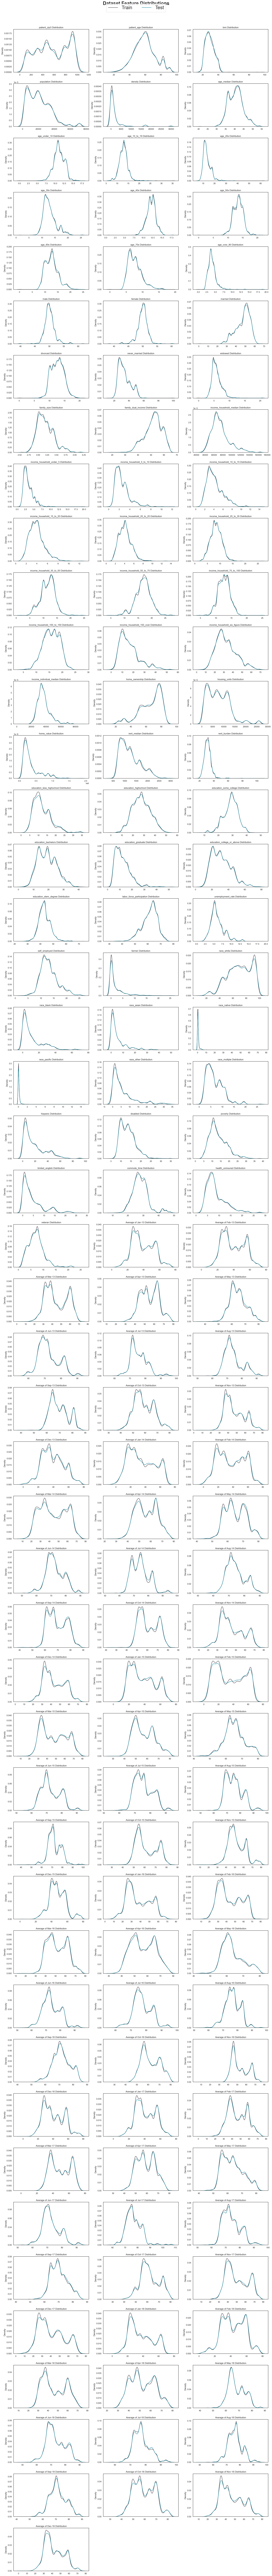

In [9]:
plot_numeric()

* the distributions of the training and test dataset are similar

# Categorical Fields (EDA)

In [10]:
def plot_cat(limit_unique=10):
    selectcols = train[CAT_COLS].nunique()<=limit_unique
    cols_ = selectcols[selectcols].index.to_list()
    n_cols = len(cols_)
    fig, ax = plt.subplots(n_cols, 2, figsize=(12, 6 * n_cols))
    for i, coluna in enumerate(cols_):    
        sns.countplot(x=train[coluna], ax=ax[i, 0])
        ax[i, 0].set_title(f'{coluna}')
        ax[i, 0].set_ylabel('Count')
        ax[i, 0].set_xlabel(coluna)
        ax[i, 0].tick_params(axis='x', labelrotation=45)

        for container in ax[i, 0].containers:
            ax[i, 0].bar_label(container, fmt='%d', label_type='center')

        s1 = train[coluna].value_counts()        

        textprops = {
            'size':8, 
            'weight': 'bold', 
            'color':'white'
        }

        ax[i, 1].pie(s1,
            autopct='%1.f%%',
            pctdistance=0.8, 
            textprops=textprops,
            labels=train[coluna].value_counts().index
        )    
        ax[i, 1].set_title(f'% {coluna}')

    plt.tight_layout()
    plt.show()
    # ax = sns.countplot(x=train['patient_race'])
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%d', label_type='center')

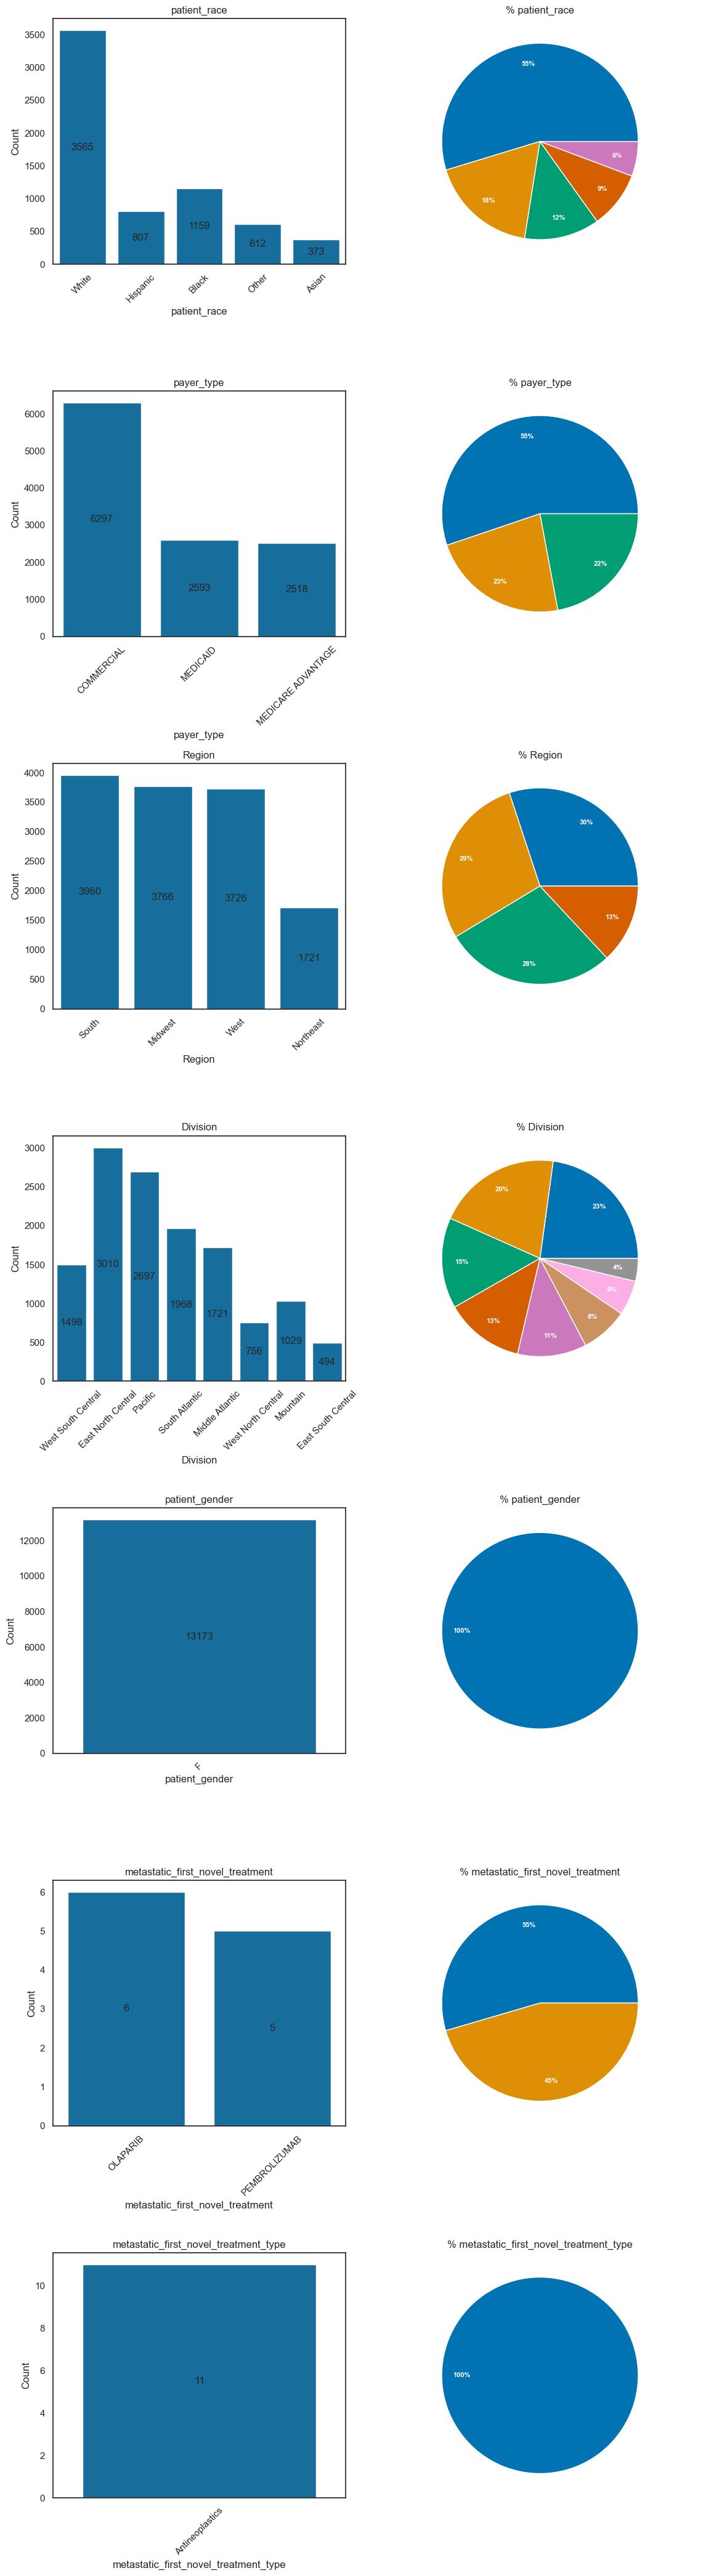

In [11]:
plot_cat()

* the 'metastatic_first_novel_treatment_type' and 'patient_gender' columns have only 1 value, being unnecessary for our models, so they will be excluded during the pipeline.
* Other categorical attributes were not plotted due to high cardinality, we will work with them later in another way.

# Inconsistency

* the attributes <b>breast_cancer diagnosis code</b>, <b>breast_cancer diagnosis_desc</b> and <b>metastatic_cancer_diagnosis_code</b> have values in the test set that are not in the training set

In [12]:
# Check for values in train that are not in test
for column in CAT_COLS:
    unique_values_train = train[column].unique()
    unique_values_test = test[column].unique()
    unique_values_only_in_train = unique_values_train[~pd.Series(unique_values_train).isin(unique_values_test)]
    
    if unique_values_only_in_train.any():
        print(f'Unique values in {column} in train but not in test:')
        print(unique_values_only_in_train)

# Check for values in test that are not in train
for column in CAT_COLS:
    unique_values_train = train[column].unique()
    unique_values_test = test[column].unique()
    unique_values_only_in_test = unique_values_test[~pd.Series(unique_values_test).isin(unique_values_train)]
    
    if unique_values_only_in_test.any():
        print(f'Unique values in {Fore.GREEN}{column}{Fore.BLACK} in test but not in train:')
        print(unique_values_only_in_test)

Unique values in breast_cancer_diagnosis_code in train but not in test:
['C50421' 'C50922' 'C5001' 'C50221' 'C509' 'C50122' 'C50619']
Unique values in breast_cancer_diagnosis_desc in train but not in test:
['Malig neoplasm of upper-outer quadrant of right male breast'
 'Malignant neoplasm of unspecified site of left male breast'
 'Malignant neoplasm of nipple and areola, female'
 'Malig neoplasm of upper-inner quadrant of right male breast'
 'Malignant neoplasm of breast of unspecified site'
 'Malignant neoplasm of central portion of left male breast'
 'Malignant neoplasm of axillary tail of unsp female breast']
Unique values in metastatic_cancer_diagnosis_code in train but not in test:
['C7971' 'C7901' 'C7962' 'C7880' 'C7972' 'C795' 'C7900']
Unique values in breast_cancer_diagnosis_code in test but not in train:
['C5021']
Unique values in breast_cancer_diagnosis_desc in test but not in train:
['Malignant neoplasm of upper-inner quadrant of breast, female']
Unique values in metastatic_

# Target

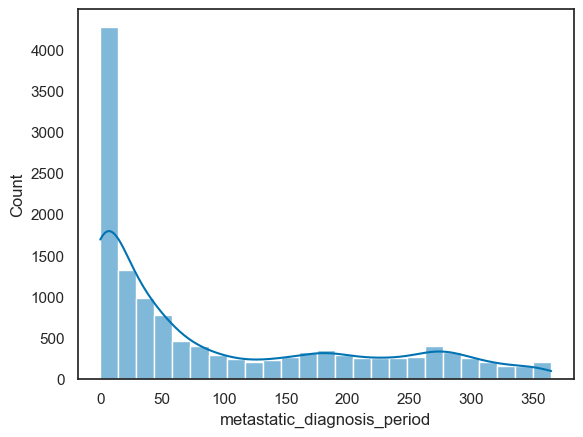

In [13]:
sns.histplot(train[TARGET],kde=True);

* the distribution of the output variable approaches a Tweedie distribution.

# Preprocess

* In this first version of the notebook, I will fill null values with the mean (numeric cases) and the mode (categorical cases).

* As we saw above, there are categories with unique values present only in the test dataset, therefore, the categories with less than unique values were classified as a new 'Code'.

In [14]:
COLS_LOW_OCCURRENCE = ['metastatic_cancer_diagnosis_code',
                       'breast_cancer_diagnosis_desc', 
                       'breast_cancer_diagnosis_code']
class ReplaceLowOccurrence(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=3):
        self.columns = columns
        self.threshold = threshold

    def fit(self, X, y=None):
        self.low_occurrence_values_ = {}
        for col in self.columns:
            self.low_occurrence_values_[col] = (X[col].value_counts() <= self.threshold)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            low_occurrence_values_col = self.low_occurrence_values_[col]
            X_copy.loc[X_copy[col].isin(low_occurrence_values_col[low_occurrence_values_col].index), col] = 'Other Code'
        return X_copy


In [15]:
def NullFill(df):
    x_copy =df.copy()
    for c in CAT_COLS:                       
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna('None')
    
    for c in NUMERIC_COLS:
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna(x_copy[c].mean())
                
        
    return x_copy

NullImputer = FunctionTransformer(NullFill)

In [16]:
# thanks @iqbalsyahakbar
def desc_cleaner(x):
    x_copy = x.copy()
    
    rep = {
        'malig ' : '',
        'malignant ' : '',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',        
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )
    
    return x_copy

DescCleaner = FunctionTransformer(desc_cleaner)

In [17]:
COLS_TO_DROP = ['metastatic_first_novel_treatment_type','patient_gender']
def dropCols(df):
    x_copy = df.copy()
    return x_copy.drop(COLS_TO_DROP,axis=1)

DropColsTransformer = FunctionTransformer(dropCols)

In [18]:
SEED = 42
splits = 5
kf = KFold(n_splits = splits, random_state = SEED, shuffle = True)
def score_model(estimator, label = ''):
    

    X = train.copy()
    y = X.pop(TARGET)
    
    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    train_scores, val_scores= [], []    
    

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
           
        model.fit(X_train, y_train)
            
        train_preds = model.predict(X_train).clip(0,None)
        val_preds = model.predict(X_val).clip(0,None)

        val_predictions[val_idx] += val_preds
        test_predictions += model.predict(test).clip(0,None) / kf.get_n_splits()
        
        train_score = mean_squared_error(y_train, train_preds, squared = False)
        val_score = mean_squared_error(y_val, val_preds, squared = False)

        train_scores.append(train_score)
        val_scores.append(val_score)
        print(f'{fold+1} - RMSE: {val_score}')
        
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')

    return val_scores, val_predictions, test_predictions

# Models

In [19]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [20]:
scores['lgbm_Tweedie'], oof['lgbm_Tweedie'],test_preds['lgbm_Tweedie'] = score_model(make_pipeline(                                                         
                                                         DescCleaner,
                                                         NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         MEstimateEncoder(cols=CAT_COLS),
                                                         DropColsTransformer,
                                                         LGBMRegressor(random_state=SEED,
                                                                       n_estimators=37,
                                                                       tweedie_variance=1.1,
                                                                       verbosity=-1,
                                                                       objective="tweedie", 
                                                                       metric="rmse")),'LGBM_TWEEDIE')


1 - RMSE: 82.17739655744718
2 - RMSE: 83.64377510453194
3 - RMSE: 81.63268309229987
4 - RMSE: 83.52182802266331
5 - RMSE: 82.56271142796687
Val Score: 82.70768 ± 0.77420 | Train Score: 76.56389 ± 0.28602 | LGBM_TWEEDIE


In [21]:
scores['lgbm_regression'], oof['lgbm_regression'],test_preds['lgbm_regression'] = score_model(make_pipeline(NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         MEstimateEncoder(cols=CAT_COLS),
                                                         DropColsTransformer,
                                                         LGBMRegressor(random_state=SEED,
                                                                       n_estimators=40,
                                                                       verbosity=-1,
                                                                       objective="regression", 
                                                                       metric="rmse")),'LGBM_Reg')


1 - RMSE: 82.44220480866286
2 - RMSE: 84.00393093868789
3 - RMSE: 81.40149249804469
4 - RMSE: 83.18531607851901
5 - RMSE: 82.92095296302625
Val Score: 82.79078 ± 0.85976 | Train Score: 74.89678 ± 0.29947 | LGBM_Reg


In [22]:
CAT_COLS_CB = [f for f in CAT_COLS if f not in COLS_TO_DROP]
scores['catboost_bernoulli'], oof['catboost_bernoulli'],test_preds['catboost_bernoulli'] = score_model(make_pipeline(
                                                         DescCleaner,
                                                         NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         DropColsTransformer,
                                                         CatBoostRegressor(random_state=SEED,
                                                                       n_estimators=1200,
                                                                       verbose=0,
                                                                       cat_features=CAT_COLS_CB,
                                                                       bootstrap_type='Bernoulli'),
                                                                        ),'CatBoost_bernoulli')


1 - RMSE: 82.18448485460443
2 - RMSE: 83.75191474583907
3 - RMSE: 81.35165433374408
4 - RMSE: 83.70749205134376
5 - RMSE: 83.25315312324025
Val Score: 82.84974 ± 0.93800 | Train Score: 71.05078 ± 0.30334 | CatBoost_bernoulli


In [23]:
scores['catboost'], oof['catboost'],test_preds['catboost'] = score_model(make_pipeline(NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         DropColsTransformer,
                                                         CatBoostRegressor(random_state=SEED,
                                                                       verbose=0,
                                                                       n_estimators=1200,
                                                                       cat_features=CAT_COLS_CB,
                                                                       bootstrap_type=None),
                                                                        ),'CatBoost')

1 - RMSE: 81.86245908653393
2 - RMSE: 83.58545585691265
3 - RMSE: 81.14540045046137
4 - RMSE: 83.42609443054097
5 - RMSE: 82.6119257302681
Val Score: 82.52627 ± 0.92589 | Train Score: 72.77344 ± 0.35916 | CatBoost


# Evaluation

In [24]:
model = Ridge(positive=True)
model.fit(oof,train[TARGET])
w = model.coef_
w /= w.sum()
display(w)

array([0.41628118, 0.1046496 , 0.01781927, 0.46124995])

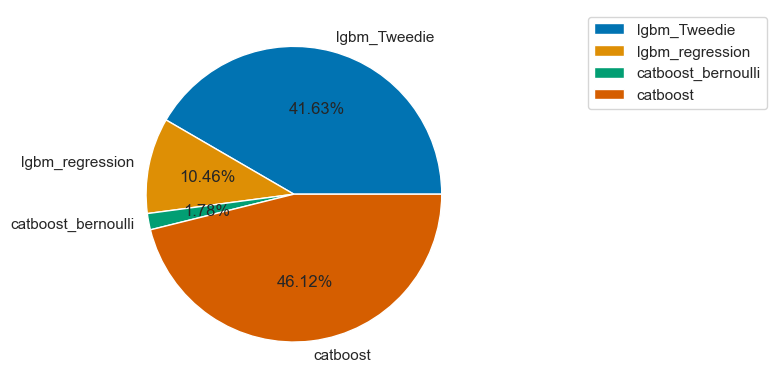

In [25]:
ax = plt.subplot()
wplot = pd.DataFrame(w, list(oof))
wplot.plot(kind='pie',y=0,autopct='%1.2f%%',ax=ax)
ax.legend( bbox_to_anchor=(1.8, 1), loc='upper right');
ax.set_ylabel(None);

In [26]:
scores['ensemble'] = mean_squared_error(train[TARGET],oof.to_numpy() @ w,squared=False)

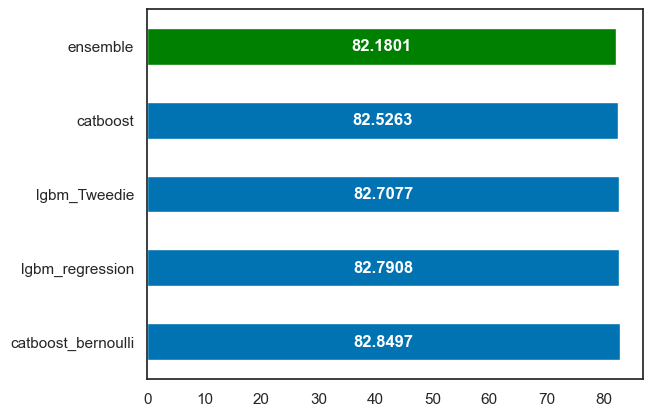

In [27]:
ax = scores.mean().sort_values(ascending=False).plot(kind='barh')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
ax.patches[-1].set_facecolor('green');

# Submission

In [28]:
predictions = test_preds.to_numpy() @ w

In [29]:
sub[TARGET] = predictions.clip(0,None).round().astype(int)

In [30]:
sub.to_csv('submission.csv',index=False)